In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import ttest_ind, chi2_contingency, normaltest

#Ekai was here

2018 Data

In [2]:
# Step 1: Load the Dataset from Parquet File

file_path = r"/Users/kianmohseni/Documents/DSC288R_Capstone/data/extracted/extracted_flight/extracted_flight_2018.parquet"

flight_data = pd.read_parquet(file_path)
print(flight_data.head())

  FlightDate            Airline Origin Dest  Cancelled  Diverted  CRSDepTime  \
0 2018-01-23  Endeavor Air Inc.    ABY  ATL      False     False        1202   
1 2018-01-24  Endeavor Air Inc.    ABY  ATL      False     False        1202   
2 2018-01-25  Endeavor Air Inc.    ABY  ATL      False     False        1202   
3 2018-01-26  Endeavor Air Inc.    ABY  ATL      False     False        1202   
4 2018-01-27  Endeavor Air Inc.    ABY  ATL      False     False        1400   

   DepTime  DepDelayMinutes  DepDelay  ...  WheelsOff  WheelsOn  TaxiIn  \
0   1157.0              0.0      -5.0  ...     1211.0    1249.0     7.0   
1   1157.0              0.0      -5.0  ...     1210.0    1246.0    12.0   
2   1153.0              0.0      -9.0  ...     1211.0    1251.0    11.0   
3   1150.0              0.0     -12.0  ...     1207.0    1242.0    11.0   
4   1355.0              0.0      -5.0  ...     1412.0    1448.0    11.0   

   CRSArrTime  ArrDelay  ArrDel15  ArrivalDelayGroups  ArrTimeBlk  \

Data Cleaning

In [3]:
# Identify Missing Values
missing_values = flight_data.isnull().sum()
print("Missing Values Count:\n", missing_values)

Missing Values Count:
 FlightDate                 0
Airline                    0
Origin                     0
Dest                       0
Cancelled                  0
                       ...  
ArrDel15              102893
ArrivalDelayGroups    102893
ArrTimeBlk                 0
DistanceGroup              0
DivAirportLandings         1
Length: 61, dtype: int64


In [4]:
# Fill Missing Values Properly
for col in flight_data.columns:
    if flight_data[col].dtype == "object":  # Categorical Columns
        flight_data.loc[:, col] = flight_data[col].fillna(flight_data[col].mode()[0])
    else:  # Numerical Columns
        flight_data.loc[:, col] = flight_data[col].fillna(flight_data[col].median())

In [5]:
# Detect and Handle Outliers
def cap_outliers(df, column):
    """
    Cap outliers using the 99th percentile method.
    """
    upper_limit = np.percentile(df[column], 99)
    lower_limit = np.percentile(df[column], 1)
    df[column] = np.where(df[column] > upper_limit, upper_limit, df[column])
    df[column] = np.where(df[column] < lower_limit, lower_limit, df[column])

# Apply outlier capping to numerical columns only
numerical_cols = flight_data.select_dtypes(include=["int64", "float64"]).columns
for col in numerical_cols:
    cap_outliers(flight_data, col)

In [6]:
# Remove Duplicates
before_duplicates = flight_data.shape[0]
flight_data.drop_duplicates(inplace=True)
after_duplicates = flight_data.shape[0]

before_duplicates, after_duplicates

(5689512, 5689512)

In [7]:
print(flight_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5689512 entries, 0 to 637613
Data columns (total 61 columns):
 #   Column                                   Dtype         
---  ------                                   -----         
 0   FlightDate                               datetime64[us]
 1   Airline                                  object        
 2   Origin                                   object        
 3   Dest                                     object        
 4   Cancelled                                bool          
 5   Diverted                                 bool          
 6   CRSDepTime                               float64       
 7   DepTime                                  float64       
 8   DepDelayMinutes                          float64       
 9   DepDelay                                 float64       
 10  ArrTime                                  float64       
 11  ArrDelayMinutes                          float64       
 12  AirTime                           

In [8]:
print(flight_data.describe())

                       FlightDate    CRSDepTime       DepTime  \
count                     5689512  5.689512e+06  5.689512e+06   
mean   2018-07-25 09:00:40.515813  1.331341e+03  1.337052e+03   
min           2018-01-01 00:00:00  5.200000e+02  5.060000e+02   
25%           2018-04-22 00:00:00  9.150000e+02  9.210000e+02   
50%           2018-08-16 00:00:00  1.323000e+03  1.327000e+03   
75%           2018-10-25 00:00:00  1.735000e+03  1.741000e+03   
max           2018-12-31 00:00:00  2.246000e+03  2.303000e+03   
std                           NaN  4.866744e+02  4.943444e+02   

       DepDelayMinutes      DepDelay       ArrTime  ArrDelayMinutes  \
count     5.689512e+06  5.689512e+06  5.689512e+06     5.689512e+06   
mean      1.197369e+01  8.706538e+00  1.463308e+03     1.216268e+01   
min       0.000000e+00 -1.500000e+01  2.300000e+01     0.000000e+00   
25%       0.000000e+00 -6.000000e+00  1.050000e+03     0.000000e+00   
50%       0.000000e+00 -2.000000e+00  1.503000e+03     0.00

Data Formatting

In [9]:
# Convert Columns to Appropriate Data Types
# Convert numerical columns stored as strings to integers or floats
for col in flight_data.columns:
    if flight_data[col].dtype == "object":  # Check if column is string-based
        try:
            flight_data[col] = pd.to_numeric(flight_data[col])  # Convert to numeric
        except ValueError:
            pass  # Skip if conversion is not possible (e.g., non-numeric text columns)

In [10]:
# Standardize Date Formatting
date_columns = ["FlightDate"]  # Update with actual date column names in your dataset

for col in date_columns:
    flight_data[col] = pd.to_datetime(flight_data[col], errors="coerce")  # Convert to datetime format

In [11]:
print(flight_data.dtypes)

FlightDate            datetime64[us]
Airline                       object
Origin                        object
Dest                          object
Cancelled                       bool
                           ...      
ArrDel15                     float64
ArrivalDelayGroups           float64
ArrTimeBlk                    object
DistanceGroup                float64
DivAirportLandings           float64
Length: 61, dtype: object


Data Aggregation

In [12]:
# Summarization - Creating Summary Statistics
summary_statistics = flight_data.describe()

# Grouping - Organizing Data into Groups Based on Airline and Month
grouped_data = flight_data.groupby(["Marketing_Airline_Network", "Month"]).agg({
    "DepDelayMinutes": ["mean", "median", "sum"],
    "ArrDelayMinutes": ["mean", "median", "sum"],
    "Distance": ["mean", "sum"]
}).reset_index()

grouped_data.head()

Marketing_Airline_Network Month DepDelayMinutes                    \
                                             mean median        sum   
0                        AA   8.0       15.029030    0.0  2713296.0   
1                        AA   9.0       11.311180    0.0  1890562.0   
2                        AA  10.0       10.639251    0.0  1860039.0   
3                        AA  11.0       10.446923    0.0  1722520.0   
4                        AA  12.0       10.663172    0.0  1799133.0   

  ArrDelayMinutes                      Distance               
             mean median        sum        mean          sum  
0       16.081978    0.0  2903392.0  701.246204  126600886.0  
1       12.191114    0.0  2037635.0  690.543523  115418135.0  
2       11.575566    0.0  2023733.0  685.246334  119800246.0  
3       11.350000    0.0  1871422.0  680.548868  112210939.0  
4       11.450096    0.0  1931906.0  692.044878  116764580.0

Data Discretization

In [13]:
# Binning Departure Delay into Categories: On-time, Moderate Delay, Severe Delay
flight_data["DepDelayCategory"] = pd.cut(
    flight_data["DepDelayMinutes"],
    bins=[-10, 0, 15, 300],  # Define custom bins
    labels=["On-time", "Moderate Delay", "Severe Delay"]
)

# Binning Distance into Short, Medium, and Long Flights
flight_data["DistanceCategory"] = pd.cut(
    flight_data["Distance"],
    bins=[0, 500, 1500, 3000],
    labels=["Short", "Medium", "Long"]
)

Data Enrichment

In [14]:
# Creating Time of Day Feature from Scheduled Departure Time
def get_time_of_day(dep_time):
    if dep_time < 600:
        return "Early Morning"
    elif dep_time < 1200:
        return "Morning"
    elif dep_time < 1800:
        return "Afternoon"
    else:
        return "Evening"

flight_data["TimeOfDay"] = flight_data["CRSDepTime"].apply(get_time_of_day)

EDA

Descriptive Statistics

In [15]:
print(flight_data.describe())

                       FlightDate    CRSDepTime       DepTime  \
count                     5689512  5.689512e+06  5.689512e+06   
mean   2018-07-25 09:00:40.515813  1.331341e+03  1.337052e+03   
min           2018-01-01 00:00:00  5.200000e+02  5.060000e+02   
25%           2018-04-22 00:00:00  9.150000e+02  9.210000e+02   
50%           2018-08-16 00:00:00  1.323000e+03  1.327000e+03   
75%           2018-10-25 00:00:00  1.735000e+03  1.741000e+03   
max           2018-12-31 00:00:00  2.246000e+03  2.303000e+03   
std                           NaN  4.866744e+02  4.943444e+02   

       DepDelayMinutes      DepDelay       ArrTime  ArrDelayMinutes  \
count     5.689512e+06  5.689512e+06  5.689512e+06     5.689512e+06   
mean      1.197369e+01  8.706538e+00  1.463308e+03     1.216268e+01   
min       0.000000e+00 -1.500000e+01  2.300000e+01     0.000000e+00   
25%       0.000000e+00 -6.000000e+00  1.050000e+03     0.000000e+00   
50%       0.000000e+00 -2.000000e+00  1.503000e+03     0.00

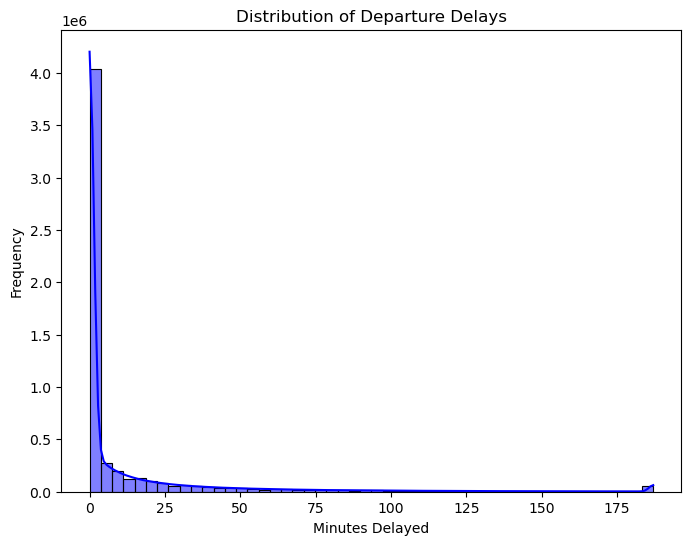

In [16]:
# Distribution of Departure Delays
plt.figure(figsize=(8, 6))
sns.histplot(flight_data["DepDelayMinutes"], bins=50, kde=True, color="blue")
plt.title("Distribution of Departure Delays")
plt.xlabel("Minutes Delayed")
plt.ylabel("Frequency")
plt.show()

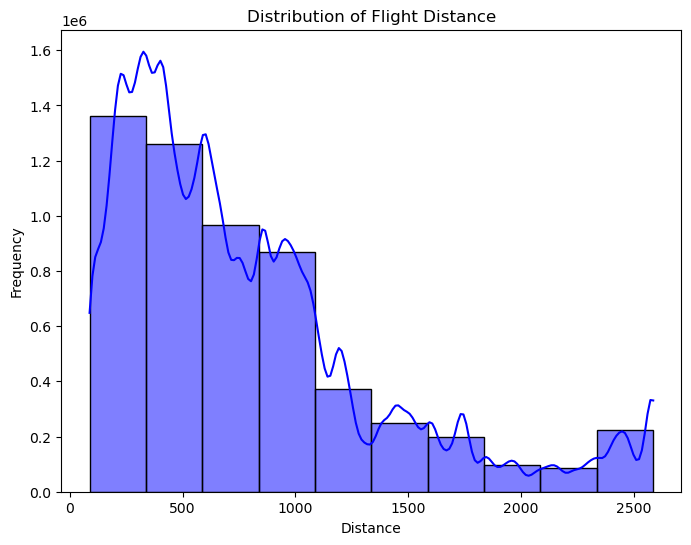

In [17]:
# Distribution of Flight Distance
plt.figure(figsize=(8, 6))
sns.histplot(flight_data["Distance"], bins=10, kde=True, color="blue")
plt.title("Distribution of Flight Distance")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

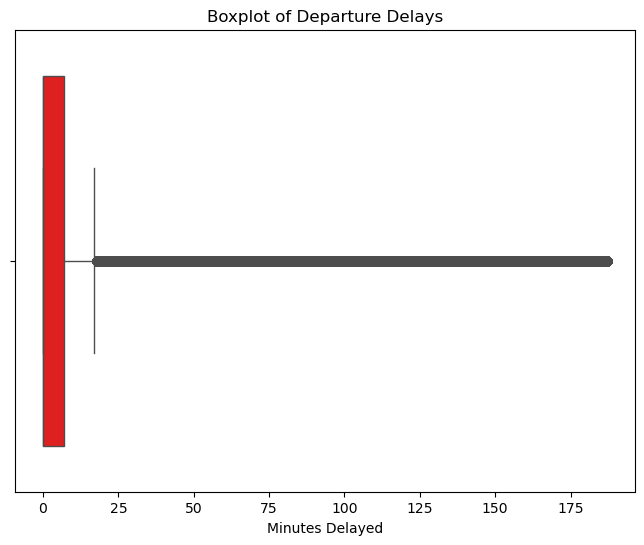

In [18]:
# Boxplot for Outlier Detection
plt.figure(figsize=(8, 6))
sns.boxplot(x=flight_data["DepDelayMinutes"], color="red")
plt.title("Boxplot of Departure Delays")
plt.xlabel("Minutes Delayed")
plt.show()

Bivariate Analysis

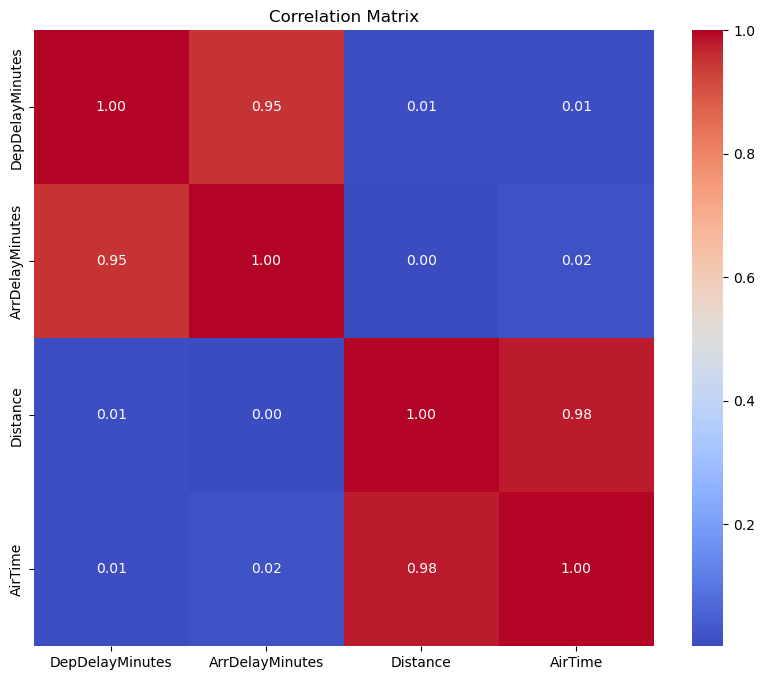

In [19]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(flight_data[["DepDelayMinutes", "ArrDelayMinutes", "Distance", "AirTime"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

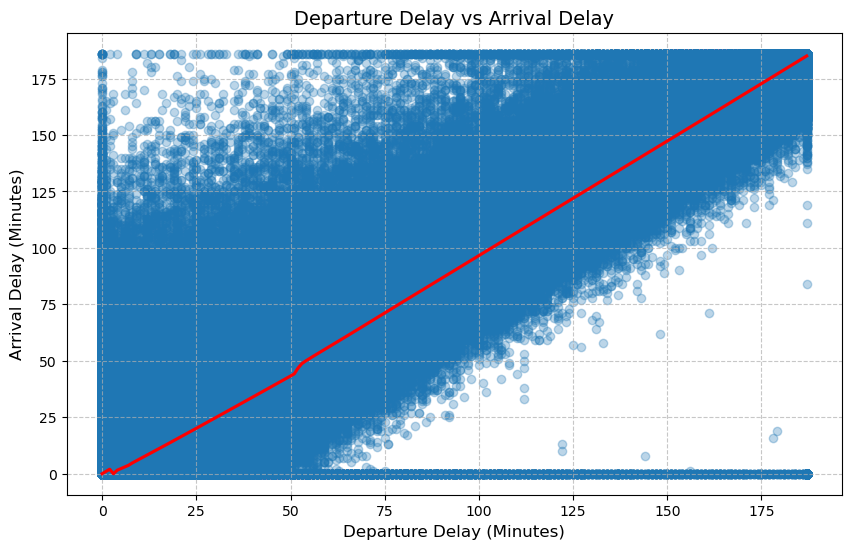

In [21]:
# Scatterplot with Trendline
plt.figure(figsize=(10, 6))

# Scatterplot with Transparency and Trendline
sns.regplot(
    x=flight_data["DepDelayMinutes"],
    y=flight_data["ArrDelayMinutes"],
    scatter_kws={"alpha": 0.3},  # Adjust transparency to reduce clutter
    line_kws={"color": "red"},  # Trendline color
    lowess=True  # Smooth trendline for better pattern visualization
)

plt.title("Departure Delay vs Arrival Delay", fontsize=14)
plt.xlabel("Departure Delay (Minutes)", fontsize=12)
plt.ylabel("Arrival Delay (Minutes)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

Inferential Statistics

In [22]:
# Apply categorization
flight_data["TimeOfDay"] = flight_data["CRSDepTime"].apply(get_time_of_day)

# Step 3: Define two groups: Morning vs Evening flights
morning_delays = flight_data[flight_data["TimeOfDay"] == "Morning"]["DepDelayMinutes"]
evening_delays = flight_data[flight_data["TimeOfDay"] == "Evening"]["DepDelayMinutes"]

# Step 4: Perform the T-Test
t_stat, p_value = ttest_ind(morning_delays, evening_delays, equal_var=False)

# Step 5: Print the results
print(f"\n✅ T-Test: Morning vs Evening Delays")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("Statistically significant difference in delays between morning and evening flights.")
else:
    print("No significant difference in delays between morning and evening flights.")


✅ T-Test: Morning vs Evening Delays
t-statistic: -258.937, p-value: 0.00000
Statistically significant difference in delays between morning and evening flights.


In [23]:
# Apply categorization
flight_data["TimeOfDay"] = flight_data["CRSDepTime"].apply(get_time_of_day)

# Define Severe Delay: 1 if delay is more than 60 minutes, otherwise 0
flight_data["SevereDelay"] = (flight_data["DepDelayMinutes"] > 60).astype(int)

# Step 3: Create a Contingency Table
contingency_table = pd.crosstab(flight_data["TimeOfDay"], flight_data["SevereDelay"])

# Step 4: Perform Chi-Square Test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Step 5: Print Results
print("\n✅ Chi-Square Test: Time of Day vs Severe Delays")
print(f"Chi-Square Statistic: {chi2_stat:.3f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-Value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("Statistically significant relationship between time of day and severe delays.")
else:
    print("No significant relationship between time of day and severe delays.")

# Step 6: Display Contingency Table
print("\n✅ Contingency Table:\n", contingency_table)



✅ Chi-Square Test: Time of Day vs Severe Delays
Chi-Square Statistic: 48168.140
Degrees of Freedom: 3
P-Value: 0.00000
Statistically significant relationship between time of day and severe delays.

✅ Contingency Table:
 SevereDelay          0       1
TimeOfDay                     
Afternoon      1903300  147383
Early Morning   159752    4824
Evening        1156925  117855
Morning        2115595   83878


Feature Importance

In [24]:
# Selecting Features and Target
# features = ["Month", "DayofMonth", "DayOfWeek", "CRSDepTime", "Distance"]
# target = "SevereDelay"

# X_train, X_test, y_train, y_test = train_test_split(flight_data[features], flight_data[target], test_size=0.2, random_state=42)

In [25]:
# Train RandomForest to Find Feature Importance
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

In [26]:
# Feature Importance Visualization
# feature_importance = pd.DataFrame({"Feature": features, "Importance": rf_model.feature_importances_}).sort_values(by="Importance", ascending=False)

In [27]:
# plt.figure(figsize=(10, 6))
# sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")
# plt.title("Feature Importance for Predicting Severe Delays")
# plt.xlabel("Importance Score")
# plt.ylabel("Feature")
# plt.show()

Time Series Analysis

In [28]:
flight_data["FlightDate"] = pd.to_datetime(flight_data["FlightDate"], format="%Y%m%d")

daily_delays = flight_data.groupby("FlightDate")[["DepDelayMinutes", "ArrDelayMinutes"]].mean().reset_index()

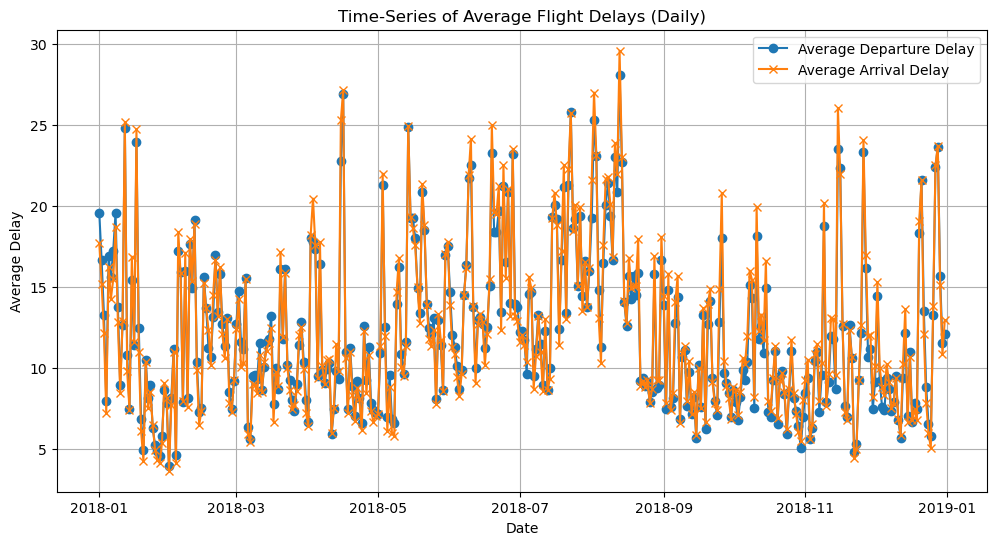

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(daily_delays["FlightDate"], daily_delays["DepDelayMinutes"], label="Average Departure Delay", marker="o")
plt.plot(daily_delays["FlightDate"], daily_delays["ArrDelayMinutes"], label="Average Arrival Delay", marker="x")
plt.title("Time-Series of Average Flight Delays (Daily)")
plt.xlabel("Date")
plt.ylabel("Average Delay")
plt.legend()
plt.grid(True)
plt.show()